<a href="https://colab.research.google.com/github/MumuXNYK/CDL/blob/main/X_Ray_Bone_Fracture_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -qq /content/gdrive/MyDrive/archive.zip -d /content

Mounted at /content/gdrive


In [ ]:


import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing import image
import matplotlib.pyplot as plt

!pip install -q visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 14.8 MB/s eta 0:00:00


In [ ]:
train_path = '/content/archive (6)/train'
val_path = '/content/archive (6)/val'


image_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
)

batch_size_val = 64

train_ds = image_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = batch_size_val,
    class_mode = 'binary',
    color_mode = 'grayscale',
    subset='training',
    shuffle=True)

val_ds = image_datagen.flow_from_directory(
    val_path,
    target_size = (224,224),
    batch_size = batch_size_val,
    class_mode = 'binary',
    color_mode = 'grayscale',
    shuffle=True)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


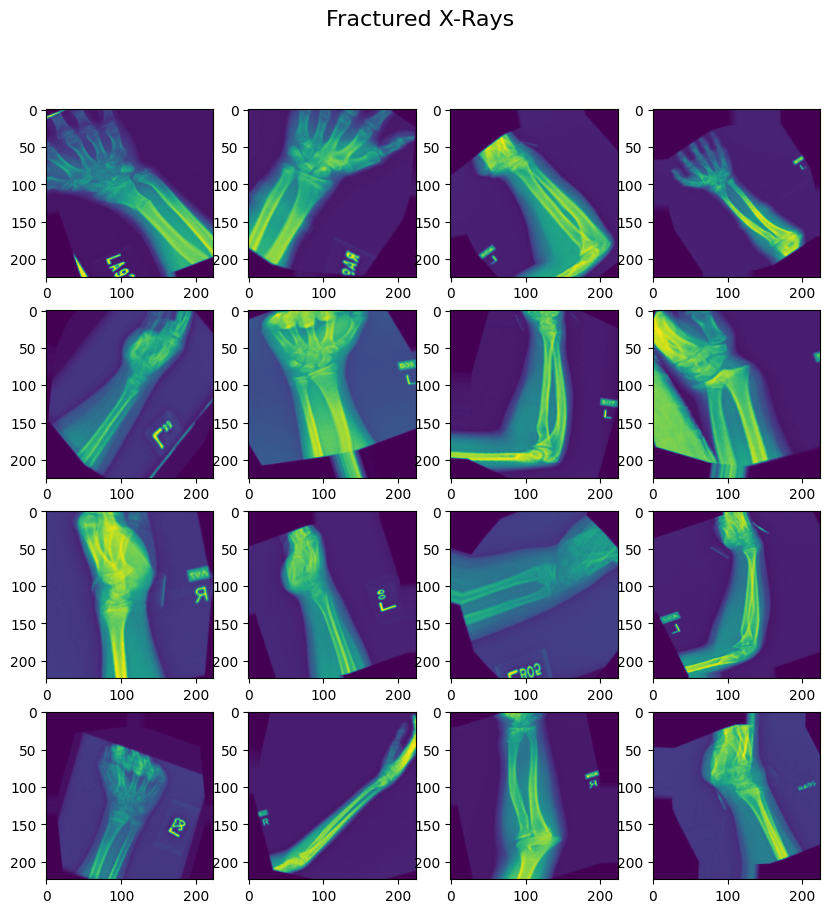

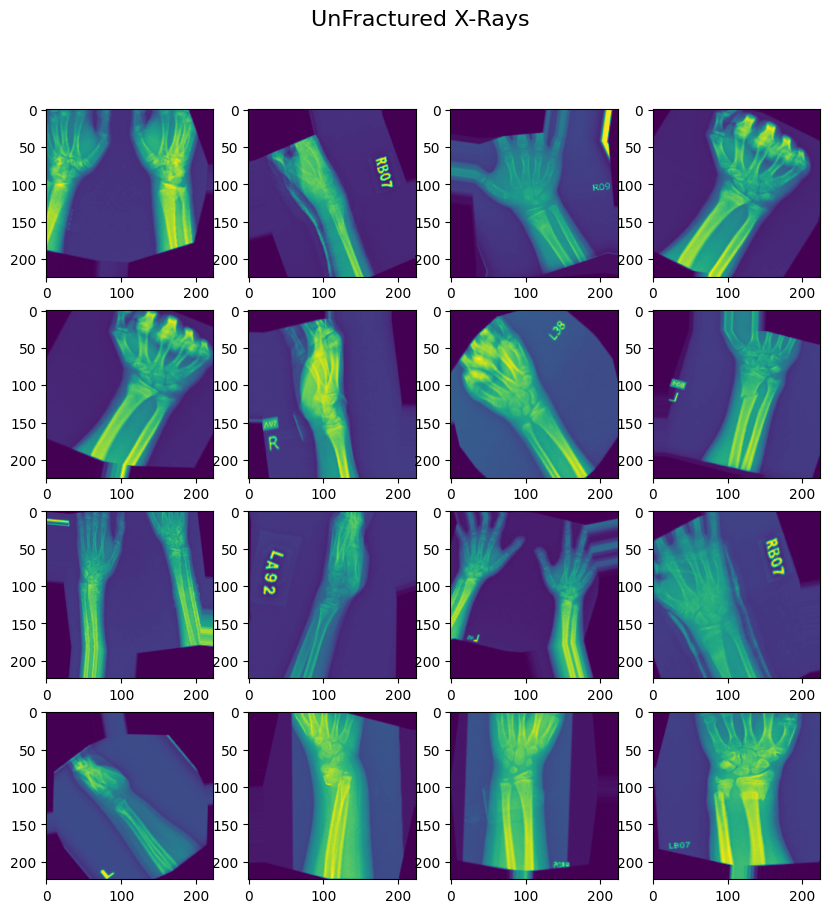

In [ ]:


frac_imgs = []
unfrac_imgs = []
for i in range(16):
  frac_imgs.append(train_ds[0][0][i])
  unfrac_imgs.append(train_ds[1][0][i])

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip(frac_imgs, axs):
    ax.imshow(img)
fig.suptitle("Fractured X-Rays", fontsize=16)
plt.show()

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip(unfrac_imgs, axs):
    ax.imshow(img)
fig.suptitle("UnFractured X-Rays", fontsize=16)
plt.show()



In [ ]:

num_classes = 1

model = keras.Sequential(
    [


        keras.Input(shape=((224, 224, 1))),
        tf.keras.layers.Rescaling(scale=1/.255, offset=0.0),



        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),



        layers.Flatten(),

        layers.Dense(512, activation='relu'),
layers.BatchNormalization(),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

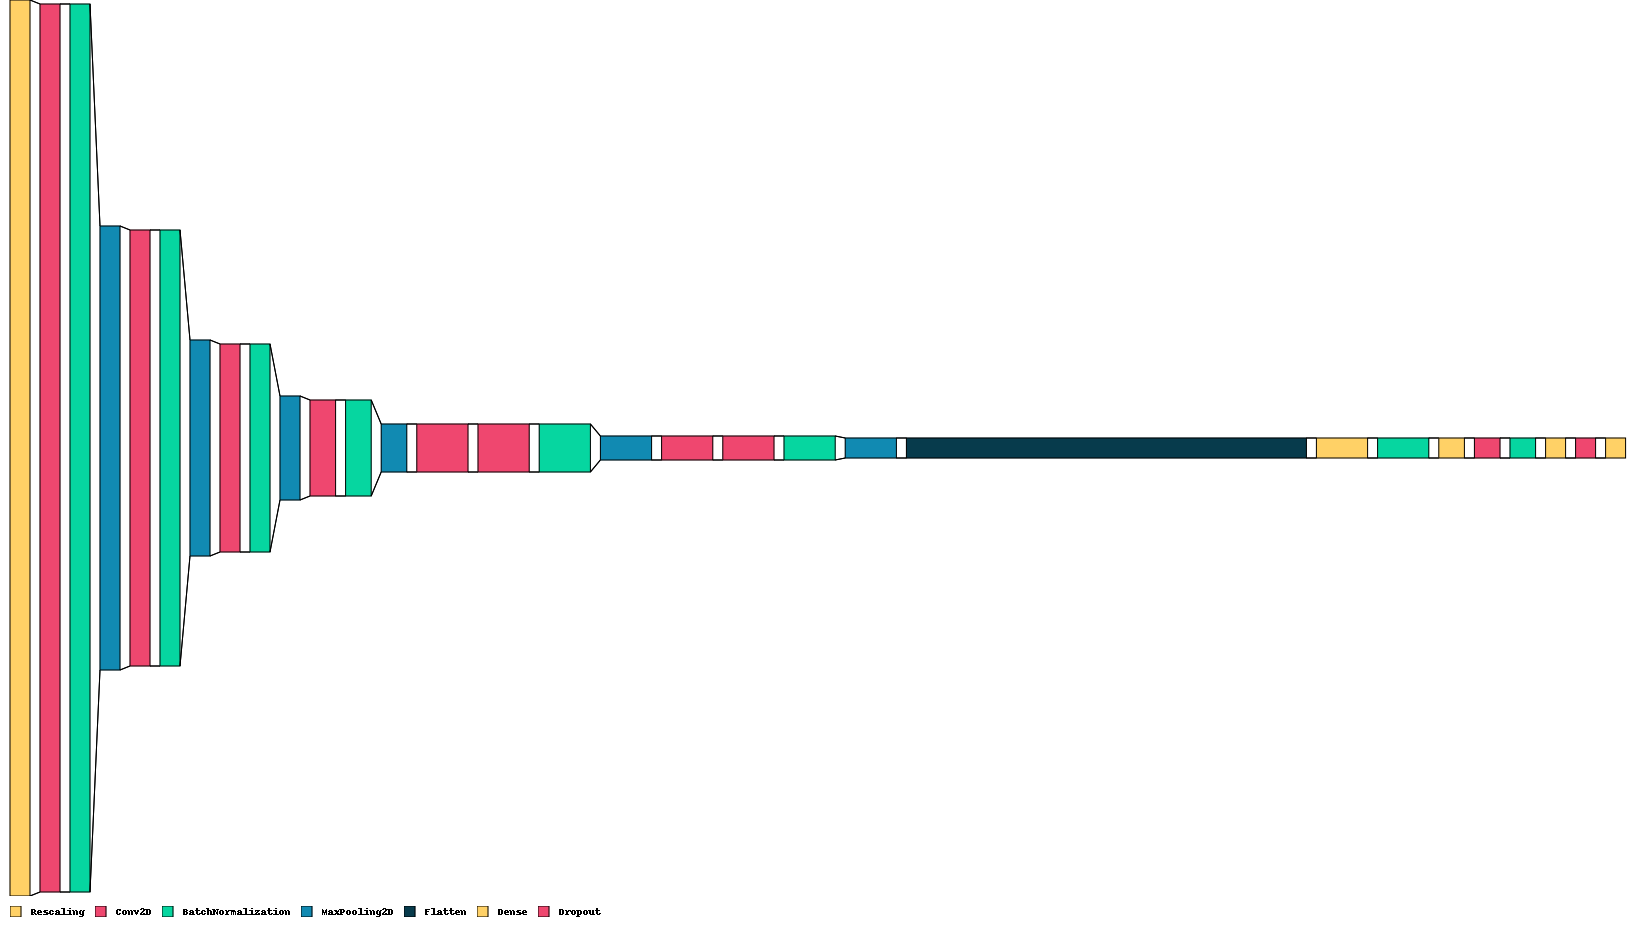

In [ ]:


visualkeras.layered_view(model, legend=True, draw_volume=False)

In [ ]:


epochs = 20
checkpoint_filepath = '/content/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
lrp=keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=round(epochs/5))



model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback, lrp])

Epoch 1/20
139/139 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.5605
Epoch 1: val_accuracy improved from -inf to 0.54167, saving model to /content/tmp/checkpoint
139/139 [==============================] - 89s 454ms/step - loss: 0.7678 - accuracy: 0.5605 - val_loss: 0.6588 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 2/20
139/139 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.6039
Epoch 2: val_accuracy improved from 0.54167 to 0.54667, saving model to /content/tmp/checkpoint
139/139 [==============================] - 60s 431ms/step - loss: 0.6720 - accuracy: 0.6039 - val_loss: 0.6505 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 3/20
139/139 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.6951
Epoch 3: val_accuracy improved from 0.54667 to 0.59833, saving model to /content/tmp/checkpoint
139/139 [==============================] - 60s 430ms/step - loss: 0.5766 - accuracy: 0.6951 - val_loss: 0.7574 - val_accuracy: 0.5983

In [ ]:


model.evaluate(train_ds)
model.evaluate(val_ds)

10/10 [==============================] - 3s 334ms/step - loss: 0.7823 - accuracy: 0.7200


[0.7822789549827576, 0.7200000286102295]

In [ ]:


model1= keras.models.clone_model(model)
model1.load_weights(checkpoint_filepath)
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model1.evaluate(train_ds)
model1.evaluate(val_ds)

10/10 [==============================] - 3s 309ms/step - loss: 0.7178 - accuracy: 0.7250


[0.7178006172180176, 0.7250000238418579]

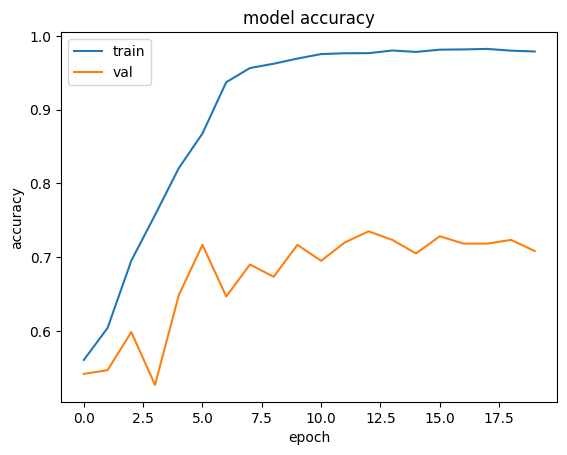

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

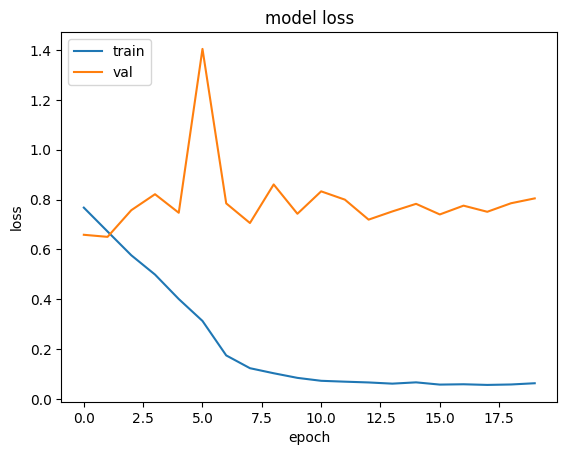

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:


model.save('/content/gdrive/MyDrive/models/complete_model')
model1.save('/content/gdrive/MyDrive/models/best_model')